In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
bc_data = pd.read_csv('breast-cancer.data.txt', sep=',', header = 0)

In [3]:
bc_data

,Class,Age,Menopause,Tumor-size,Inv-nodes,Node-caps,Deg-malig,Breast,Breast-quad,Irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


## 1. Plot the bar plot of the number of samples in each class for each possible age range.

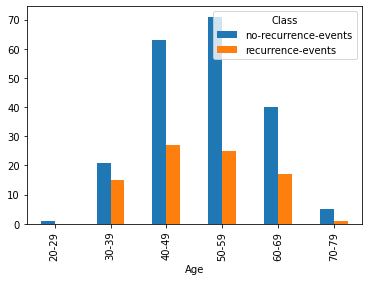

In [8]:
bc_data.groupby(['Age','Class']).size().unstack().plot(kind='bar')

## Pick attributes as the first split of a decision tree classifier

In [5]:
def Info(sample, split, data):
    values_dict = data[split].value_counts()
    total_counts = data.shape[0]
    Info_Split = 0
    
    for val in values_dict.index:
        val_counts = values_dict[val]
        split_value = data[split] == val
        sample_counts = data[split_value][sample].value_counts()
        if len(sample_counts.index) ==1:
            Info_val= 0
        else:
            p_non_rec = sample_counts[0]/val_counts
            p_rec = sample_counts[1]/val_counts
            Info_val = (val_counts/total_counts)*(-p_rec*math.log(p_rec, 2) - p_non_rec*math.log(p_non_rec, 2))
        Info_Split += Info_val
        
    return Info_Split

In [6]:
bc_data['Class'].value_counts()

no-recurrence-events    201
recurrence-events        85
Name: Class, dtype: int64

In [7]:
#information gain of all samples in Class I(201, 85)
p_non_rec = bc_data['Class'].value_counts()[0]/bc_data.shape[0]
p_rec = bc_data['Class'].value_counts()[1]/bc_data.shape[0]
Info_Class = round(-p_rec*math.log(p_rec, 2) - p_non_rec*math.log(p_non_rec, 2),3)
Info_Class

0.878

In [9]:
bc_data_na = bc_data.replace('?', np.nan)
for col in bc_data_na.columns:
    print(col)
    if col != 'Class':
        print(bc_data_na.groupby([col, 'Class']).size().reset_index())

Class
Age
      Age                 Class   0
0   20-29  no-recurrence-events   1
1   30-39  no-recurrence-events  21
2   30-39     recurrence-events  15
3   40-49  no-recurrence-events  63
4   40-49     recurrence-events  27
5   50-59  no-recurrence-events  71
6   50-59     recurrence-events  25
7   60-69  no-recurrence-events  40
8   60-69     recurrence-events  17
9   70-79  no-recurrence-events   5
10  70-79     recurrence-events   1
Menopause
  Menopause                 Class    0
0      ge40  no-recurrence-events   94
1      ge40     recurrence-events   35
2      lt40  no-recurrence-events    5
3      lt40     recurrence-events    2
4   premeno  no-recurrence-events  102
5   premeno     recurrence-events   48
Tumor-size
   Tumor-size                 Class   0
0         0-4  no-recurrence-events   7
1         0-4     recurrence-events   1
2       10-14  no-recurrence-events  27
3       10-14     recurrence-events   1
4       15-19  no-recurrence-events  23
5       15-19     recurr

In [10]:
Initial_Gain = 0
new_split = ''

for col in bc_data_na.columns:
    if col != 'Class':
        Gain  = round(Info_Class - Info('Class', col, bc_data_na), 3)
        print('Information Gain for', col, 'is', Gain)
        
        if Gain > Initial_Gain:
            Initial_Gain = Gain
            new_split = col
            
print(new_split, 'gives maximum information gain')

Information Gain for Age is 0.011
Information Gain for Menopause is 0.002
Information Gain for Tumor-size is 0.057
Information Gain for Inv-nodes is 0.069
Information Gain for Node-caps is 0.08
Information Gain for Deg-malig is 0.077
Information Gain for Breast is 0.003
Information Gain for Breast-quad is 0.015
Information Gain for Irradiat is 0.026
Node-caps gives maximum information gain


## Use Gini Index to decide the best partitions.

In [17]:
def Split_Gini(col, data):
    range_index = data[col].str.contains('-')
    col_range = data[range_index]
    total_counts = data.shape[0]
    
    Gini_min = 0
    Split_min = ''
    if col_range.shape[0]  > 0: 
        data['col_Lbound'] = data[col].str.split(pat='-', expand= True)[0]
        data['col_Rbound'] = data[col].str.split(pat='-', expand= True)[1]
        left = data['col_Lbound'].unique().astype(int).tolist()
        right = data['col_Rbound'].unique().astype(int).tolist()
        
        splits = []       
        for i in range(len(right)-1):
            split = (right[i] + left[i+1])/2
            splits.append(split)
                    
        for split in splits:
            
            group0 = data[data['col_Rbound'].astype(int) <= split]
            group1 = data[data['col_Rbound'].astype(int) > split]
            
            group0_no_counts = group0['Class'].value_counts()[0]
            group0_counts = group0.shape[0]
            Gini_group0 = (group0_counts/total_counts) * (1-(group0_no_counts/group0_counts)**2 - 
                                                   ((group0_counts-group0_no_counts)/group0_counts**2))
            

            group1_no_counts = group1['Class'].value_counts()[0]
            group1_counts = group1.shape[0]        
            Gini_group1 = (group1_counts/total_counts) * (1-(group1_no_counts/group1_counts)**2 - 
                                                   ((group1_counts-group1_no_counts)/group1_counts**2))
            Gini = round(Gini_group0 + Gini_group1, 3)
            print(Gini)
            if Gini_min == 0 and Gini !=0:
                Gini_min = Gini
                Split_min = split
                
            elif Gini<Gini_min:
                Gini_min = Gini
                Split_min = split
                
    return (Split_min, Gini_min)

In [12]:
def Gini(sample, attribute, data):
    values_dict = data[attribute].value_counts()
    total_counts = data.shape[0]
    Gini_attribute = 0
    
    for val in values_dict.index:
        val_counts = values_dict[val]
        attribute_value = data[attribute] == val
        sample_counts = data[attribute_value][sample].value_counts()
  
        p_non_rec = sample_counts[0]/val_counts
        p_rec = sample_counts[1]/val_counts
        Gini_val = (val_counts/total_counts)*(1-p_rec**2 - p_non_rec**2)
        Gini_attribute += Gini_val
        
    return Gini_attribute

In [13]:
bc_data_na['Node-caps'].value_counts()

no     222
yes     56
Name: Node-caps, dtype: int64

In [14]:
#Gini of all samples in Class
Gini_Class = round(1-p_rec**2 - p_non_rec**2,3)
Gini_Class

0.418

In [15]:
Gini_Node = round(Gini('Class', "Node-caps", bc_data_na),3)
Gini_Node

0.371

In [18]:
#For the attribute which have multiple unique values, the Gini
Gini_Inv_nodes = Split_Gini('Inv-nodes', bc_data_na)
Gini_Inv_nodes

0.467
0.483
0.466
0.483
0.498
0.5


(7.0, 0.466)